## Importations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')


from scripts.descriptors import *

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_triarylboranes = df_total[df_total.group == "triarylboranes"]

## Generate SMILES

In [22]:
all_possible_smiles = []
smi_base = 'C1(*)=C(*)C(*)=C(*)C(*)=C1B(C2=C(*)C(*)=C(*)C(*)=C2*)C3=C(*)C(*)=C(*)C(*)=C3*' #triarylboranes 
frags = ['N', 'O', 'Cl', 'F', 'Br', 'C', 'OC', 'N(C)C',
          '[H]',"C#N", "C(C)(C)C", "C(F)(F)F","[N+]([O-])=O"]
for frag in frags :
    L = list(smi_base)
    L[3]=L[21]=L[33]=L[51]=L[58]=L[76]= frag
    for frag2 in frags :
        L[8] = L[17] = L[37] = L[46] = L[62] = L[71] = frag2
        for frag3 in frags :
            L[12] = L[42] = L[67] = frag3
            new_L = "".join(L)
            mol  = Chem.MolFromSmiles(new_L)
            smi = Chem.MolToSmiles(mol)
            all_possible_smiles.append(smi)   

In [41]:
df_all_smiles = pd.DataFrame()
df_all_smiles['SMILES']= all_possible_smiles
df_all_smiles = df_all_smiles.set_index('SMILES')
df_all_smiles.to_csv('../tables/data/all_possible_smiles_triarylboranes.csv')

In [3]:
# Load data
df = pd.read_csv('../tables/data/all_possible_smiles_triarylboranes.csv')
all_smiles = df['SMILES'].values

In [4]:
not_in_DB_smi = [smi for smi in all_smiles if smi not in df_triarylboranes.index]

## Featurize molecules

In [5]:
def generate_morgan_matrix(smiles, n_bit):#une ligne = description d'une molecule
    """Compute ECFP fingerprints for a list of SMILES strings."""
    list_fp = []
    
    for smi in smiles : 
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=n_bit)
        fp_array = np.array(fp)
        list_fp.append(fp_array)
    
    morgan_matrix = np.array(list_fp)
    
    return(morgan_matrix)

def create_descriptors(smiles, descriptors, depth = 3, data = None, structure = None, n_bit = 1024):
    """ smiles : list of smiles for the molecules
        depth : in case of RAC
        descriptors: "fingerprints", "RAC", "quantum"; type : str
        returns : X: descriptors of the molecules """
    if descriptors == "RAC":
        X = []
        for smi in smiles:
            X.append(rac_descriptor(smi,depth))
    if descriptors == "fingerprints":
        X = generate_morgan_matrix(smiles, n_bit)
    if descriptors == "quantum":
        X = []
        df = pd.Series(data) 
        for smi in smiles :
            X.append(get_features(df, smi))
        X = np.array(X)
    if descriptors == "rdkit":
        featurizer = dc.feat.RDKitDescriptors()
        X = featurizer.featurize(smiles) 
  
    if descriptors == "Hammett":##Substituents descriptors
        df = df_sigman
        X = []
        for smi in smiles :
            sub_ortho = id_substructure_ortho(smi, structure)
            features_ortho = np.array(df['ortho'].set_index('R-ortho').loc[sub_ortho])


            sub_meta = id_substructure_meta(smi, structure)
            features_meta = np.array(df['meta'].set_index('R-meta').loc[sub_meta])

            sub_para = id_substructure_para(smi, structure)
            features_para = np.array(df['para'].set_index('R-para').loc[sub_para])

            features = np.concatenate((features_ortho, features_meta, features_para))

            X.append(features)
        X = np.array(X)
    return(X)

In [7]:
all_fingerprints = create_descriptors(all_smiles, 'fingerprints')

In [8]:
np.shape(all_fingerprints)

(2197, 1024)

In [26]:
df_fingerprints = pd.DataFrame(all_fingerprints)

df_clusters = pd.concat([df, df_fingerprints], axis=1)

## K-means clustering

In [39]:
n_clustering = 2 #number of repeat of K-means clustering, 10 is good

n_clusters = 50 # number of molecules to select using clustering
n_init = 10 # can reduce this to save time

for i in range(n_clustering):
    km = KMeans(n_clusters=n_clusters, n_init=n_init)
    km.fit(all_fingerprints)
    df_clusters[str(i)] = km.labels_ # add cluster labels to the dataframe
    selected_smiles = []
    
    for cluster_id in sorted(df_clusters[str(i)].unique()):
        cluster_data = df_clusters[df_clusters[str(i)] == cluster_id].iloc[:,0:1025]
        centroid = km.cluster_centers_[cluster_id]
        cluster_data_not_in_DB = cluster_data[cluster_data['SMILES'].isin(not_in_DB_smi)]
        
        distances = np.linalg.norm(cluster_data_not_in_DB.iloc[:, 1:].values - centroid, axis=1)
        representative_smi = cluster_data_not_in_DB.iloc[np.argmin(distances)]['SMILES'] # look for the molecule closer to the centroid that 
                                                                                         # is not already in the DB
        
        selected_smiles.append(representative_smi)
    
    df_kmeans = pd.DataFrame()
    df_kmeans['SMILES']=selected_smiles
    df_kmeans.to_csv(f'../tables/data/K-means/kmeans_50_{i}.csv')
    

#clusters_df['selected'] = clusters_df['SMILES'].apply(lambda x: 1 if x in selected_smiles else 0)

#pd.DataFrame({'SMILES': selected_smiles}).to_csv('selected_kmeans.csv', index=False)

### Analyze all K-means clustering results

In [40]:
kmeans_0 = pd.read_csv('../tables/data/K-means/kmeans_50_0.csv')
kmeans_1 = pd.read_csv('../tables/data/K-means/kmeans_50_1.csv')

In [49]:
all_kmeans = pd.DataFrame()

In [50]:
all_kmeans["0"]= kmeans_0["SMILES"]
all_kmeans["1"]= kmeans_1["SMILES"]

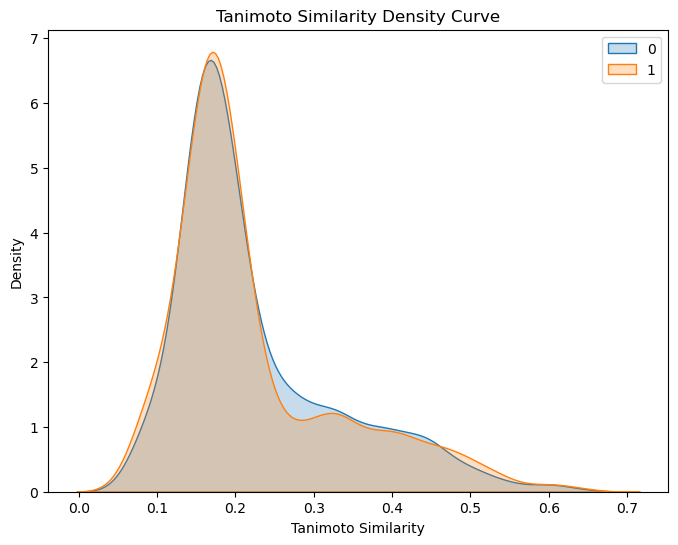

In [51]:
plt.figure(figsize=(8, 6))

for col in all_kmeans.columns :
    
    smiles_list = all_kmeans[col]
    
    # Calculate Morgan fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048) for smi in smiles_list]

    # Calculate Tanimoto similarities
    similarity_matrix = []
    for i in range(len(smiles_list)):
        similarities = [AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j]) for j in range(len(smiles_list))]
        similarity_matrix.append(similarities)

    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, columns=smiles_list, index=smiles_list)

    # Flatten the upper triangle of the similarity matrix for the kernel density estimate
    flat_similarity_values = df.values[np.triu_indices(len(smiles_list), k=1)]

    # Create a density curve

    sns.kdeplot(flat_similarity_values, fill=True, label = f'{col}')
    
plt.title("Tanimoto Similarity Density Curve")
plt.xlabel("Tanimoto Similarity")
plt.legend()
plt.ylabel("Density")
plt.show()

## Save selected smiles

In [60]:
df_all_kmeans = pd.concat([kmeans_0, kmeans_1])

In [76]:
df = pd.DataFrame()
df['SMILES'] = df_all_kmeans['SMILES'].value_counts()[:50].keys() # get the 50 more represented smiles accross running the K-means algo

In [78]:
df.to_csv('../tables/data/K-means/50_smi_to_run_triarylboranes_kmeans.csv')

## Represent data

In [71]:
X_embedded_all = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(all_fingerprints)

In [79]:
df_selected_kmeans = pd.read_csv('../tables/data/K-means/50_smi_to_run_triarylboranes_kmeans.csv')

In [100]:
smi = df_selected_kmeans.at[0,  'SMILES']

In [103]:
smi in list(df_selected_kmeans['SMILES'])

True

In [107]:
indexes_kmeans = []
for i, smi in enumerate(all_smiles):
    if smi in list(df_selected_kmeans['SMILES']):
        indexes_kmeans.append(i)

In [108]:
df_X_embedded_all = pd.DataFrame(X_embedded_all)
df_X_embedded_kmeans = df_X_embedded_all.iloc[indexes_kmeans]

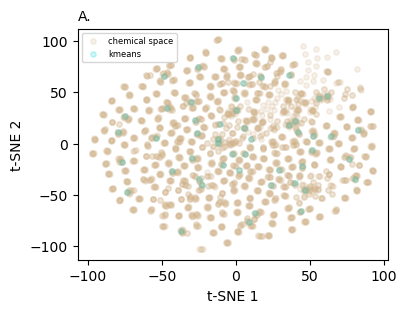

In [109]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot()

ax.scatter(X_embedded_all[:,0], X_embedded_all[:,1], c = 'tan', s = 15, alpha = 0.2, marker = "o", label = 'chemical space')
ax.scatter(df_X_embedded_kmeans[0], df_X_embedded_kmeans[1], c = 'darkturquoise', s = 15,  alpha = 0.2, marker = 'o', label = 'kmeans')


plt.legend(loc = 'best', fontsize = 6)
plt.ylabel('t-SNE 2')
plt.xlabel('t-SNE 1')
ax.set_title('A.', loc='left', fontsize =10)
plt.show()
